## Pair Programming Asunciones Regresión Lineal

En este ejercicio de pair programming seguiréis usando el dataset que seleccionasteis.


El objetivo de este pair programming es que evaluéis si vuestro set de datos cumple todas las asunciones que se deben cumplir para hacer una regresión lineal. Recordamos que estas asunciones son:

- Normalidad (ya la deberíais haber evaluado)
- Homogeneidad de varianzas
- Independencia de las variables
- Cada asunción la deberéis testar de forma visual y analítica.

In [6]:
!pip install researchpy
!pip install scipy

In [7]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import random 

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Estadísticos
# ------------------------------------------------------------------------------
from scipy import stats
import researchpy as rp
from scipy.stats import levene


plt.rcParams["figure.figsize"] = (10,8) 

In [8]:
df=pd.read_csv("../datos/sephora_website_dataset.csv")
df.head(2)

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0


### Asunción de normalidad

En anteriores ejercicios de pair ya vimos que nuestra variable respuesta no es normal. De todos modos se incluye aquí el análisis de la VR usando el test de Kolmogorov Smirnov. 

Para usarlo correctamente y que nos muestre la normalidad añadimos el parámetro 'norm'. Otros parámetros podrían mostrarnos distribuciones uniformes o binomiales, entre otras.  

In [10]:
from scipy.stats import kstest


In [11]:
kstest(df['rating'], 'norm')

KstestResult(statistic=0.9426341392117457, pvalue=0.0)

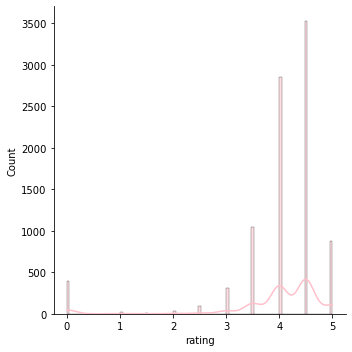

In [36]:


sns.displot(df['rating'], kde = True, color = "pink");



Vemos que el pvalor es < que 0.05, por lo que podemos rechazar la hipótesis nula: no creemos que los datos sigan una distribución normal. 

### Asunción de homocedasticidad u homogeneidad de las varianzas



Con los siguientes test queremos ver si las variables numéricas cumplen o no las asunciones de homocedasticidad/homogeneidad. 

Usando la siguiente función crearemos un regplot para visualizar los patrones de dispersión en cuanto a una recta: si los puntos se dispersan de manera constante a lo largo de la recta podremos hablar de homocedasticidad, de lo contrario tendremos un patrón de heterocedasticidad y no se cumplirá la asunción. 

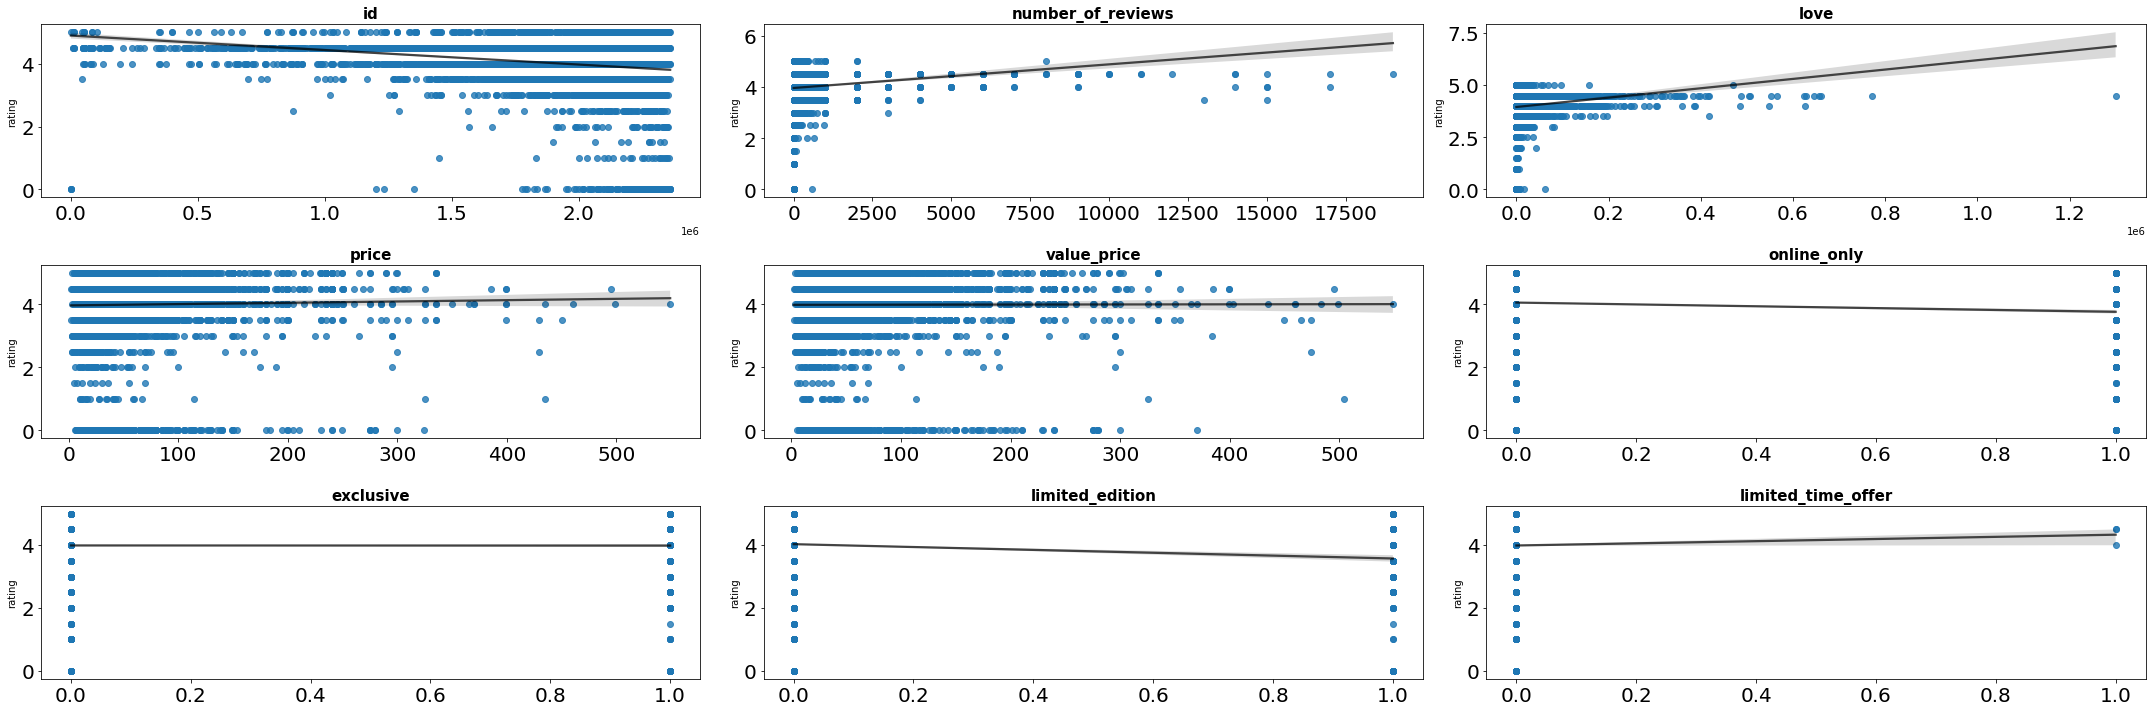

In [14]:

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (30, 10))

 
axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).drop('rating', axis=1)
columnas_numeric = columnas_numeric.columns

for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = df,
        x = colum,
        y = 'rating',
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")

    axes[i].tick_params(labelsize = 20)

    axes[i].set_xlabel("")
    
fig.tight_layout();

*Vemos que no se cumple la asunción.*

Pasamos a probar la asunción de manera analítica. 

Como nuestros datos en la VR no tienen normalidad usamos el test de Levene utilizando la mediana.

Empezamos con las variables categóricas. Tenemos muy pocas así que decidimos probar con una de marketing.

In [25]:
df['MarketingFlags_content'].unique()

array(['online only', 'exclusive · online only', '0',
       'limited edition · exclusive · online only',
       'limited edition · online only', 'exclusive',
       'limited edition · exclusive', 'limited edition',
       'limited time offer',
       'limited time offer · limited edition · exclusive'], dtype=object)

La exploramos y vemos que su contenido es bastante confuso y no aportaría nada a nuestro análisis: ver la relación entre love y rating. 

Seguimos intentando con las variables numéricas. Para eso definiremos un dataframe que solo incluya las variables numéricas. 

In [26]:

numericas = df.select_dtypes(include = np.number)
numericas.head(2)

,id,rating,number_of_reviews,love,price,value_price,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,4.0,4,3002,66.0,75.0,1,0,0,0
1,2044816,4.5,76,2700,66.0,66.0,1,0,0,0


Creamos un diccionario para almacenar los resultados de los test.

Seleccionamos solo las columnas numéricas y eliminamos la columna de rating.

Iteramos por la lista de las columnas numéricas, calculamos el pvalor del test y lo almacenamos en el diccionario resultados. 

In [30]:
resultados = {}

numericas_col = df.select_dtypes(include = np.number).drop("rating", axis = 1).columns

for col in numericas_col:
    statistic, p_val = levene(df[col], df.rating, center='median')
    resultados[col] = p_val


In [29]:
resultados

{'id': 0.0,
 'number_of_reviews': 3.017607266651439e-181,
 'love': 4.898166175329371e-233,
 'price': 0.0,
 'value_price': 0.0,
 'online_only': 1.4983618775594097e-278,
 'exclusive': 9.11237633562295e-231,
 'limited_edition': 0.0,
 'limited_time_offer': 0.0}

Las variables number of reviews, love, online only y exclusive tienen un valor mayor que 0.05, así que cumplen la asunción de homogeneidad. 

En cambio, id (no relevante), price, limited edition y limited time offer tienen un valor menor que 0.05 no la cumplen: no tienen varianzas constantes. 

### Asunción de independencia

Comprobamos la independencia de las variables love y rating para ver la fuerza de la relación de dependencia, si la hubiera. Para eso usaremos el crosstab y analizamos los resultados con el test chi cuadrado. 

In [31]:
crosstab, test_results, expected = rp.crosstab(df['love'], df['rating'],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")

In [32]:
crosstab.head()

rating                                                          
rating    0.0   1.0  1.5  2.0   2.5   3.0   3.5   4.0   4.5   5.0   All
love                                                                   
0        0.29  0.01  0.0  0.0  0.04  0.07  0.28  0.37  0.58  0.33  1.97
4        0.01  0.00  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.01
6        0.01  0.00  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.01
12       0.01  0.00  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.01
17       0.01  0.00  0.0  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.01

In [33]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 15138.0) =,22558.4294
1,p-value =,0.0000
2,Cramer's V =,0.5229


- Nuestro pvalor es menor que 0.05, así que nuestras variables son dependientes. 
- La V de Cramer es más cercana a 1 que a 0, así que también nos muestra dependencia. 

-> Cuando el love aumente también aumentará el rating. 
